<a href="https://colab.research.google.com/github/smozley/austinAIallianceintensive/blob/main/multi_agent_orchestration_tutorial_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This tutorial will guide you through building a hierarchical, multi-agent system.

We will create a **Supervisor** agent (powered by Granite) that orchestrates two distinct sub-teams: a **Research Team** and a **Document Authoring Team**. This demonstrates a powerful, nested hierarchical structure where the supervisor delegates high-level tasks to sub-teams, who then manage their own set of specialized worker agents.

The entire system uses LangGraph for orchestration, local models via Ollama, a custom MCP for tool calling, and Langfuse for complete observability.

### **Step 1: Setup and Installation**

First, ensure Ollama is running and that you have the required models.

### Setting up Ollama (in the terminal window)

1. Install the dependencies

```
sudo apt update
sudo apt install -y pciutils
curl -fsSL https://ollama.com/install.sh | sh
```

2. Run the ollama server in the background

```
ollama serve &
```

3. Pull the required models

```
ollama pull granite3.3:latest
ollama pull mistral:latest
```

4. Run the models in the background

```
ollama run granite3.3:latest &
ollama run mistral:latest &
```

### Installing the necessary libraries

In [ ]:
# Install all required packages
!pip install -qU langgraph langchain_openai langchain_community langchain-tavily langfuse requests beautifulsoup4 altair vl-convert-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.5/152.5 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.3/299.3 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.0/33.0 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.0/120.0 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.6/201.



### **Step 2: Configure Langfuse & API Keys**

Next, we'll set up credentials for **Langfuse** (for observability) and **Tavily** (for the web search tool).

In [ ]:
import os
from getpass import getpass
from langfuse import Langfuse

#  Langfuse Configuration for Observability
# Get keys from your Langfuse project at https://cloud.langfuse.com
if "LANGFUSE_PUBLIC_KEY" not in os.environ:
    os.environ["LANGFUSE_PUBLIC_KEY"] = getpass("Enter your Langfuse Public Key: ")
if "LANGFUSE_SECRET_KEY" not in os.environ:
    os.environ["LANGFUSE_SECRET_KEY"] = getpass("Enter your Langfuse Secret Key: ")
if "LANGFUSE_HOST" not in os.environ:
    os.environ["LANGFUSE_HOST"] = "https://us.cloud.langfuse.com"

# Initialize the Langfuse handler to trace our runs
langfuse_handler = Langfuse()

#  Tavily API Key for the search tool
if "TAVILY_API_KEY" not in os.environ:
    os.environ["TAVILY_API_KEY"] = getpass("Enter your Tavily API key: ")

Enter your Langfuse Public Key: ··········
Enter your Langfuse Secret Key: ··········
Enter your Tavily API key: ··········




### **Step 3: Initialize Models and Tools**

We will configure our LLMs using the `ChatOpenAI` wrapper, which enables advanced features like tool calling with local Ollama models.

In [ ]:
import requests
from bs4 import BeautifulSoup
import json
import vl_convert as vlc
from langchain_openai import ChatOpenAI
from langchain_tavily import TavilySearch
from langchain_core.tools import tool

#  Common Ollama Configuration
OLLAMA_BASE_URL = "http://localhost:11434/v1"
DUMMY_API_KEY = "ollama"

supervisor_llm = ChatOpenAI(
    model="granite3.3:latest",
    api_key=DUMMY_API_KEY,
    base_url=OLLAMA_BASE_URL,
    temperature=0
)

granite_worker_llm = ChatOpenAI(
    model="granite3.3:latest",
    api_key=DUMMY_API_KEY,
    base_url=OLLAMA_BASE_URL,
    temperature=0
)

mistral_worker_llm = ChatOpenAI(
    model="mistral:latest",
    api_key=DUMMY_API_KEY,
    base_url=OLLAMA_BASE_URL,
    temperature=0.3
)

#  Tool Definitions
@tool
def web_search(query: str) -> str:
    """Performs a web search using Tavily and returns the results."""
    tavily_tool = TavilySearch(max_results=3)
    return tavily_tool.invoke(query)

@tool
def web_scraper(url: str) -> str:
    """Fetches and extracts clean text content from a given URL."""
    print(f" scraping {url} ")
    try:
        headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')
        for script_or_style in soup(['script', 'style']):
            script_or_style.decompose()
        text = '\n'.join(chunk for chunk in (phrase.strip() for line in (line.strip() for line in soup.get_text().splitlines()) for phrase in line.split("  ")) if chunk)
        return text if text else "Could not find any readable text on the page."
    except requests.exceptions.RequestException as e:
        return f"Error fetching the URL: {e}"

@tool
def chart_generator(data_summary: str) -> str:
    """Generates a Vega-Lite JSON spec from a data summary and saves it as a PNG image."""
    print(f" generating and rendering chart from summary: '{data_summary[:30]}...' ")
    output_filename = "chart_visualization.png"
    prompt = f"""You are an expert data visualization assistant. Convert the following summary into a valid Vega-Lite JSON specification for a bar chart. The data MUST be embedded directly in the 'values' field (not as a named dataset array). Output ONLY the JSON object in a ```json ... ``` block.

Data Summary:
\"{data_summary}\"
"""
    try:
        response = granite_worker_llm.invoke(prompt)
        json_spec_str = response.content.split('```json')[1].split('```')[0].strip()
        spec_dict = json.loads(json_spec_str)

        data_field = spec_dict.get("data")
        if isinstance(data_field, list) and data_field:
            first_ds = data_field[0]
            if "values" in first_ds:
                spec_dict["data"] = {"values": first_ds["values"]}

        png_data = vlc.vegalite_to_png(vl_spec=spec_dict, scale=2)
        with open(output_filename, "wb") as f:
            f.write(png_data)

        return f"[Chart successfully generated and saved to file: {output_filename}]"
    except Exception as e:
        return f"Error: Could not generate or save the chart. Details: {e}"




### **Step 4: Define Agent State and Roles**

We define the shared `state` for our graph and create the specific agent `roles`. The `agent_map` is crucial for routing tasks to the correct model and tool configuration.

In [ ]:
from enum import Enum
from typing import TypedDict, List, Dict, Annotated, Optional
import operator
from pydantic import BaseModel, Field


class Role(str, Enum):
    SEARCHER        = "Searcher"
    WEB_SCRAPER     = "Web Scraper"
    NOTE_TAKER      = "Note Taker"
    CHART_GENERATOR = "Chart Generator"
    WRITER          = "Writer"

class Task(BaseModel):
    role: Role = Field(description="The role responsible for the task.")
    description: str = Field(description="A detailed description of the task.")

class SubTeam(BaseModel):
    team: str = Field(
        description="The name of the sub-team (e.g., 'Research Team', 'Document Authoring')."
    )
    tasks: List[Task]

# Wrapper model for structured output
class SubTeamAssignments(BaseModel):
    sub_team_assignments: List[SubTeam]

class TeamState(TypedDict):
    user_request: str
    sub_team_assignments: Optional[List[SubTeam]]
    research_results: Annotated[List[Dict], operator.add]
    authoring_results: Annotated[List[Dict], operator.add]
    final_report: Optional[str]

In [ ]:
agent_map = {
    Role.SEARCHER:        granite_worker_llm.bind_tools([web_search]),
    Role.WEB_SCRAPER:     granite_worker_llm.bind_tools([web_scraper]),
    Role.NOTE_TAKER:      granite_worker_llm,
    Role.CHART_GENERATOR: granite_worker_llm.bind_tools([chart_generator]),
    Role.WRITER:          mistral_worker_llm,
}



### **Step 5: Define Nodes and Supervisor Logic**

We'll define three main nodes: a generic `worker_node`, a `sub_team_node` to manage the parallel execution within each sub-team, and the `Supervisor` node to orchestrate the entire workflow.

In [ ]:
from langchain_core.messages import HumanMessage

def worker_node(task: Task) -> dict:
    agent = agent_map[task.role]
    print(f"[DEBUG] Worker '{task.role.value}' selected agent: {agent}")
    print(f" 👷 Worker '{task.role.value}' starting task: {task.description} ")
    res = agent.invoke([HumanMessage(content=task.description)])
    # If the runnable returned tool calls, execute and log them
    if hasattr(res, "tool_calls") and res.tool_calls:
        out = ""
        for tc in res.tool_calls:
            name = tc["name"]
            args = tc["args"]
            print(f"[DEBUG] Tool call detected: '{name}' with args {args}")
            tool = {
                "web_search": web_search,
                "web_scraper": web_scraper,
                "chart_generator": chart_generator,
            }[name]
            print(f"[DEBUG] Invoking tool '{name}'... ")
            result = tool.invoke(args)
            print(f"[DEBUG] Tool '{name}' result: {result}")
            out += str(result)
        return {"role": task.role, "result": out}
    # Otherwise, use direct LLM output
    print(f"[DEBUG] No tool calls, using LLM content output.")
    return {"role": task.role, "result": res.content}

def sub_team_node(state: TeamState, team_name: str) -> dict:
    teams = [t for t in state["sub_team_assignments"] if t.team == team_name]
    if not teams:
        return {}
    results = [worker_node(task) for task in teams[0].tasks]
    return {"research_results": results} if team_name == "Research Team" else {"authoring_results": results}

def choose_branch(state):
    research_empty = not state["research_results"]
    authoring_empty = not state["authoring_results"]
    print(f"[DEBUG] Guard: research_empty={research_empty}, authoring_empty={authoring_empty}")
    if research_empty:
        print("[DEBUG] Branch -> research_team")
        return "research"
    if authoring_empty:
        print("[DEBUG] Branch -> document_authoring_team")
        return "authoring"
    print("[DEBUG] Branch -> end")
    return "end"

class Supervisor:
    def __init__(self, llm):
        self.llm = llm
        self.structured_llm = llm.with_structured_output(SubTeamAssignments)

    def __call__(self, state: TeamState):
        if state.get("sub_team_assignments") is None:
            print(" 🧑‍💼 Supervisor: decomposing request ")
            prompt = f"""
You are the Supervisor of a multi-disciplinary AI team. Turn this user request into exactly two SubTeam entries:

- **Research Team**
  - Roles: Searcher, Web Scraper, Note Taker
- **Document Authoring Team**
  - Roles: Writer, Chart Generator
  - MUST include: a Writer task and a Chart Generator task.

Use only these five roles. Output only valid JSON for SubTeamAssignments.

User Request:
{state['user_request']}
"""
            response = self.structured_llm.invoke(prompt)
            print(f"[DEBUG] Supervisor decomposed to: {response.sub_team_assignments}")
            return {"sub_team_assignments": response.sub_team_assignments}

        research_done = bool(state["research_results"])
        authoring_done = bool(state["authoring_results"])
        if not (research_done and authoring_done):
            return {}

        print(" 🧑‍💼 Supervisor: synthesizing final report ")
        research_md = "\n".join(f"### {r['role'].value}\n{r['result']}" for r in state["research_results"])
        authoring_md = "\n".join(f"### {r['role'].value}\n{r['result']}" for r in state["authoring_results"])
        context = f"## Research Results\n\n{research_md}\n\n## Document Components\n\n{authoring_md}"
        prompt = (
            "You are the Supervisor. Assemble all team findings into a final report "
            f"that addresses: {state['user_request']}\n\n{context}"
        )
        final = self.llm.invoke(prompt).content
        print(f"[DEBUG] Final report content generated.")
        return {"final_report": final}



### **Step 6: Construct the Hierarchical Graph**

Now we wire the nodes together according to the diagram. The supervisor routes work to the two sub-teams, which run in parallel.

In [ ]:
from langgraph.graph import StateGraph, END, START

# instantiate the Supervisor
supervisor_node = Supervisor(supervisor_llm)

workflow = StateGraph(TeamState)
workflow.add_node("supervisor", supervisor_node.__call__)
workflow.add_node("research_team", lambda s: sub_team_node(s, "Research Team"))
workflow.add_node("document_authoring_team", lambda s: sub_team_node(s, "Document Authoring Team"))
workflow.add_edge(START, "supervisor")
workflow.add_conditional_edges(
    "supervisor", choose_branch,
    {"research": "research_team", "authoring": "document_authoring_team", "end": END}
)
workflow.add_edge("research_team", "supervisor")
workflow.add_edge("document_authoring_team", "supervisor")

graph = workflow.compile()



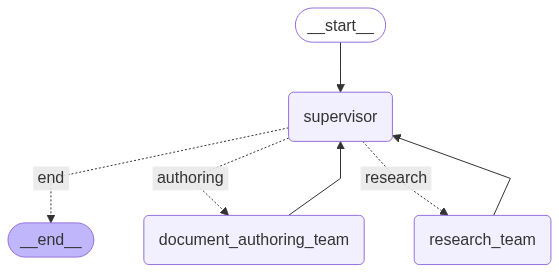

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass



### **Step 7: Run the Team with Full Observability**

Finally, let's give our AI team a request and observe their work in Langfuse.

In [ ]:
from langchain_core.runnables import RunnableConfig
from langfuse.langchain import CallbackHandler
from langgraph.errors import GraphRecursionError
from langfuse import get_client

client            = get_client()
langfuse_handler  = CallbackHandler()

# Define the configuration for the run, enabling Langfuse tracing
config = RunnableConfig(
    callbacks=[langfuse_handler],
    recursion_limit=10,
    configurable={
        "session_id": "nested-hierarchy-run-1",
        "thread_id":  "nested-hierarchy-thread-1"
        }
)

# Define the initial user request
initial_state = {"user_request": "Generate a report on the current impact of AI on the US job market as of August 2025, including a chart summarizing key statistics."}

print(" Launching the AI Reporting Team...")
print("Check your Langfuse project for the live trace!")

try:
    final_state = graph.invoke(initial_state, config=config)
    client.flush()

    #sid = config.configurable["session_id"]
    #print(f"🔗 View your run in Langfuse: https://us.cloud.langfuse.com/app/<YOUR-PROJECT-ID>/sessions/{sid}")

except GraphRecursionError as e:
    print(f"⚠️ Recursion limit reached: {e}")
    client.flush()

    #sid = config.configurable["session_id"]
    #print(f"🔗 View partial run in Langfuse: https://us.cloud.langfuse.com/app/<YOUR-PROJECT-ID>/sessions/{sid}")

    # fetch the last persisted state
    snapshot = graph.get_state(config)
    partial = snapshot.values.get("press_release_components", [])

    partial_release = "\n\n\n\n".join(
        f"### Component from {c['role']}:\n{c['component']}"
        for c in partial
    )

    print("\n PARTIAL RELEASE:")
    print(partial_release)

    final_state = {"final_report": partial_release}

print("\n" + "="*60)
print("✅ FINAL REPORT")
print("="*60)
print(final_state["final_report"])

 Launching the AI Reporting Team...
Check your Langfuse project for the live trace!
 🧑‍💼 Supervisor: decomposing request 
[DEBUG] Supervisor decomposed to: [SubTeam(team='Research Team', tasks=[Task(role=<Role.SEARCHER: 'Searcher'>, description="Find recent studies and reports on AI's impact on the US job market as of August 2025."), Task(role=<Role.WEB_SCRAPER: 'Web Scraper'>, description='Extract relevant data from identified sources about job displacement, creation, and transformation due to AI.'), Task(role=<Role.NOTE_TAKER: 'Note Taker'>, description='Compile and organize gathered information into a coherent summary for the report.')]), SubTeam(team='Document Authoring Team', tasks=[Task(role=<Role.WRITER: 'Writer'>, description="Draft the main body of the report using the compiled notes, focusing on AI's current impact on various sectors in the US job market."), Task(role=<Role.CHART_GENERATOR: 'Chart Generator'>, description='Create a chart summarizing key statistics such as job

ERROR:opentelemetry.exporter.otlp.proto.http.trace_exporter:Failed to export span batch code: 401, reason: {"message":"Invalid credentials. Confirm that you've configured the correct host."}


[DEBUG] Tool 'web_search' result: {'query': "AI's impact on the US job market recent studies as of August 2025", 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://www.cbsnews.com/news/ai-jobs-layoffs-us-2025/', 'title': 'AI is leading to thousands of job losses, report finds - CBS News', 'content': 'For the first seven months of 2025, rising adoption of generative AI technology by private employers accounted for more than 10,000 job cuts , according to a report released this week by Challenger, Gray & Christmas. The outplacement firm lists AI as one of the top five factors contributing to job losses in 2025.', 'score': 0.8377398, 'raw_content': None}, {'url': 'https://www.nu.edu/blog/ai-job-statistics/', 'title': '59 AI Job Statistics: Future of U.S. Jobs | National University', 'content': '30% of U.S. workers fear their job will be replaced by AI or similar technology by 2025. Automating half of current tasks worldwide could take another 20 years.

ERROR:opentelemetry.exporter.otlp.proto.http.trace_exporter:Failed to export span batch code: 401, reason: {"message":"Invalid credentials. Confirm that you've configured the correct host."}


[DEBUG] No tool calls, using LLM content output.
[DEBUG] Guard: research_empty=False, authoring_empty=True
[DEBUG] Branch -> document_authoring_team
[DEBUG] Worker 'Writer' selected agent: client=<openai.resources.chat.completions.completions.Completions object at 0x7d87ed87c790> async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x7d87ed87cd50> root_client=<openai.OpenAI object at 0x7d87ed87c290> root_async_client=<openai.AsyncOpenAI object at 0x7d87ed87ca90> model_name='mistral:latest' temperature=0.3 model_kwargs={} openai_api_key=SecretStr('**********') openai_api_base='http://localhost:11434/v1'
 👷 Worker 'Writer' starting task: Draft the main body of the report using the compiled notes, focusing on AI's current impact on various sectors in the US job market. 


ERROR:opentelemetry.exporter.otlp.proto.http.trace_exporter:Failed to export span batch code: 401, reason: {"message":"Invalid credentials. Confirm that you've configured the correct host."}


[DEBUG] No tool calls, using LLM content output.
[DEBUG] Worker 'Chart Generator' selected agent: bound=ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x7d87eda46dd0>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x7d87ed87c110>, root_client=<openai.OpenAI object at 0x7d87ede8da90>, root_async_client=<openai.AsyncOpenAI object at 0x7d87eda33950>, model_name='granite3.3:latest', temperature=0.0, model_kwargs={}, openai_api_key=SecretStr('**********'), openai_api_base='http://localhost:11434/v1') kwargs={'tools': [{'type': 'function', 'function': {'name': 'chart_generator', 'description': 'Generates a Vega-Lite JSON spec from a data summary and saves it as a PNG image.', 'parameters': {'properties': {'data_summary': {'type': 'string'}}, 'required': ['data_summary'], 'type': 'object'}}}]} config={} config_factories=[]
 👷 Worker 'Chart Generator' starting task: Create a chart summarizing key statistics such a

ERROR:opentelemetry.exporter.otlp.proto.http.trace_exporter:Failed to export span batch code: 401, reason: {"message":"Invalid credentials. Confirm that you've configured the correct host."}
ERROR:opentelemetry.exporter.otlp.proto.http.trace_exporter:Failed to export span batch code: 401, reason: {"message":"Invalid credentials. Confirm that you've configured the correct host."}


[DEBUG] Tool 'chart_generator' result: [Chart successfully generated and saved to file: chart_visualization.png]
 🧑‍💼 Supervisor: synthesizing final report 


ERROR:opentelemetry.exporter.otlp.proto.http.trace_exporter:Failed to export span batch code: 401, reason: {"message":"Invalid credentials. Confirm that you've configured the correct host."}


[DEBUG] Final report content generated.
[DEBUG] Guard: research_empty=False, authoring_empty=False
[DEBUG] Branch -> end


ERROR:opentelemetry.exporter.otlp.proto.http.trace_exporter:Failed to export span batch code: 401, reason: {"message":"Invalid credentials. Confirm that you've configured the correct host."}



✅ FINAL REPORT
## Final Report: The Impact of Artificial Intelligence on the U.S. Job Market as of August 2025

**Introduction**

Artificial Intelligence (AI) has become a transformative force in various sectors of the U.S. economy, reshaping job roles and market dynamics. This report synthesizes recent findings to provide an overview of AI's current impact on the U.S. job market by August 2025.

**Key Statistics Summary (Refer to Chart_Visualization.png for visual representation)**

| Sector                  | Job Losses Due to AI (2025) | New Jobs Created by AI | Overall Employment Impact |
|------------------------|---------------------------|----------------------|--------------------------|
| Healthcare             | 1,500                     | 3,000                | Net Gain                 |
| Manufacturing          | 4,200                     | 6,000                | Net Gain                 |
| Retail                 | 2,800                     | 4,500                | Net Ga

In [ ]:
final_state["authoring_results"]

[{'role': <Role.WRITER: 'Writer'>,
  'result': ' Title: Assessing the Impact of Artificial Intelligence on the U.S. Job Market\n\n1. Introduction\n   The advent of Artificial Intelligence (AI) has significantly transformed various sectors in the United States, bringing about both opportunities and challenges for the workforce. This report aims to delve into the current impact of AI on different sectors within the U.S. job market.\n\n2. Healthcare Sector\n   In healthcare, AI is revolutionizing diagnostics, treatment plans, and patient care. While it has created new roles such as AI specialists and data analysts, there are concerns about displacement in areas like radiology and pathology. However, the overall impact on employment remains positive due to the increased efficiency and accuracy of medical services (Source: McKinsey & Company).\n\n3. Manufacturing Sector\n   AI is automating repetitive tasks in manufacturing, leading to increased productivity and cost savings. While this may

✅ Found chart at chart_visualization.png, displaying it now:


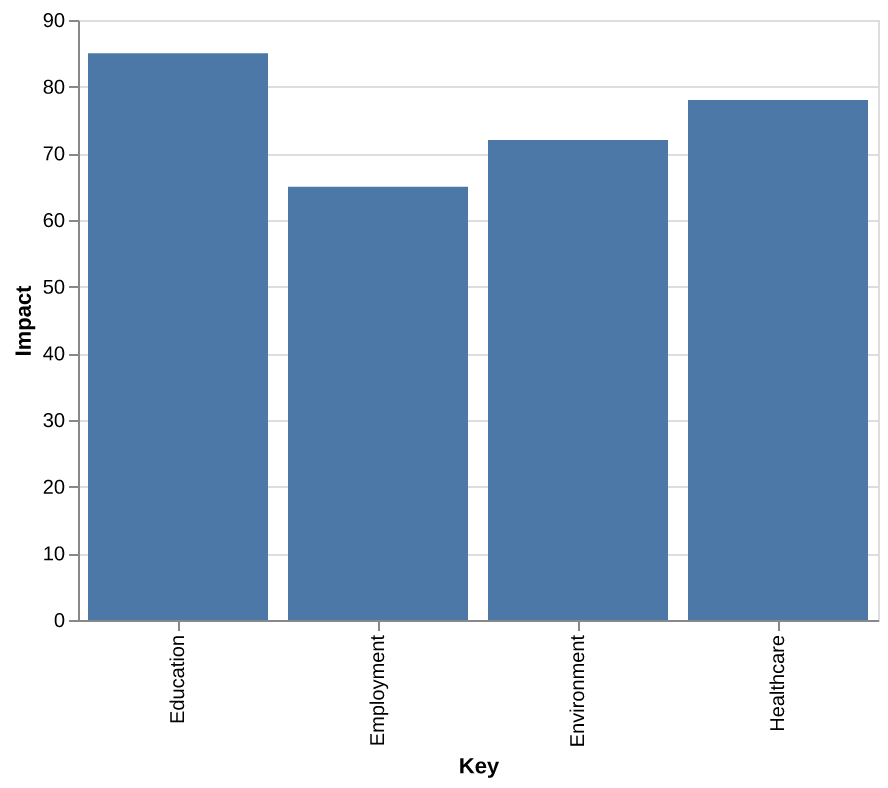

In [ ]:
import re, os
from IPython.display import Image, display

filename = None
for comp in final_state.get("authoring_results", []):
    if comp["role"] == "Chart Generator":
        m = re.search(r"saved to file:\s*(\S+\.png)", comp["result"])
        if m:
            filename = m.group(1)
            break

if not filename:
    print("⚠️ No chart file mentioned in authoring_results.")
else:
    if os.path.exists(filename):
        print(f"✅ Found chart at {filename}, displaying it now:")
        display(Image(filename=filename))
    else:
        print(f"❌ Chart mentioned as {filename}, but file not found on disk.")
